# Sai Surya Salalith Mantha  9463553709
# saisurym@usc.edu

# Steps:
1. Find the Sift features.
2. Matches before RANSAC
3. Matches using RANSAC
4. Essential Matrix.
5. Rotation and Translation Matrix
6. Projection Matrix and Triangulation.
5. plot 3D points.

In [3]:
# import neccessary libraries
import cv2
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [58]:
# SFM() fucntion takes two images as Input
# shows the matches, Essential matrix, Rotation and translation matrix and 3d-points.
def SFM(image1,image2):
    MIN_MATCH_COUNT = 10

    #TODO: Load Different Image Pairs
    img1=cv2.imread(image1)
    img2=cv2.imread(image2)

    #TODO: Replace K with given Intrinsic Matrix
    K = np.array([[518.86, 0., 285.58],
                  [0., 519.47, 213.74],
                  [0.,   0.,   1.]])


    ###############################
    #1----SIFT feature matching---#
    ###############################

    #detect sift features for both images
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    #use flann to perform feature matching
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    if len(good)>MIN_MATCH_COUNT:
        p1 = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        p2 = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                       singlePointColor = None,
                       flags = 2)

    img_siftmatch = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
    
    
    ####### Display matchings before Ransac
    print("Before RANSAC:")
    plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(img_siftmatch)
    plt.show()

    #########################
    #2----essential matrix--#
    #########################
    E, mask = cv2.findEssentialMat(p1, p2, K, cv2.RANSAC, 0.999, 1.0);

    matchesMask = mask.ravel().tolist()

    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                       singlePointColor = None,
                       matchesMask = matchesMask, # draw only inliers
                       flags = 2)

    img_inliermatch = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
    
    ####### Display matchings After Ransac
    print("After RANSAC:")
    plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(img_inliermatch)
    plt.show()
    print ("Essential matrix:")
    print (E)

    ####################
    #3----recoverpose--#
    ####################

    points, R, t, mask = cv2.recoverPose(E, p1, p2)
    print ("Rotation:")
    print (R)
    print ("Translation:")
    print (t)
    # p1_tmp = np.expand_dims(np.squeeze(p1), 0)
    p1_tmp = np.ones([3, p1.shape[0]])
    p1_tmp[:2,:] = np.squeeze(p1).T
    p2_tmp = np.ones([3, p2.shape[0]])
    p2_tmp[:2,:] = np.squeeze(p2).T
    print ((np.dot(R, p2_tmp) + t) - p1_tmp)

    #######################
    #4----triangulation---#
    #######################

    #calculate projection matrix for both camera
    M_r = np.hstack((R, t))
    M_l = np.hstack((np.eye(3, 3), np.zeros((3, 1))))

    P_l = np.dot(K,  M_l)
    P_r = np.dot(K,  M_r)

    # undistort points
    p1 = p1[np.asarray(matchesMask)==1,:,:]
    p2 = p2[np.asarray(matchesMask)==1,:,:]
    p1_un = cv2.undistortPoints(p1, K, None)
    p2_un = cv2.undistortPoints(p2, K, None)
    p1_un = np.squeeze(p1_un)
    p2_un = np.squeeze(p2_un)

    #triangulate points this requires points in normalized coordinate
    point_4d_hom = cv2.triangulatePoints(M_l, M_r, p1_un.T, p2_un.T)
    point_3d = point_4d_hom / np.tile(point_4d_hom[-1, :], (4, 1))
    point_3d = point_3d[:3, :].T

    #############################
    #5----output 3D pointcloud--#
    #############################
    #TODO: Display 3D points
    print("3-D points")
    print("---------------------------Multiple Views-------------------------")
    
    fig = plt.figure(num=None, figsize=(14, 9), dpi=80, facecolor='w', edgecolor='k')
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    ax1.scatter(point_3d[:,0], point_3d[:,1], point_3d[:,2])
    ax1.view_init()
    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    ax2.scatter(point_3d[:,0], point_3d[:,1], point_3d[:,2])
    ax2.view_init(20,20)
    ax3 = fig.add_subplot(2, 2, 3, projection='3d')
    ax3.scatter(point_3d[:,0], point_3d[:,1], point_3d[:,2])
    ax3.view_init(20,40)
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    ax4.scatter(point_3d[:,0], point_3d[:,1], point_3d[:,2])
    ax4.view_init(20,60)
    plt.show()
    

    

    
    
    
    
    
    
    
    
    
#     fig = plt.figure()
#     ax = Axes3D(fig)
#     ax.autoscale(enable=True,axis='both',tight=None)
#     ax.scatter(point_3d[:,0], point_3d[:,1], point_3d[:,2])
# #     ax.view_init(20,60)
#     plt.show()


Before RANSAC:


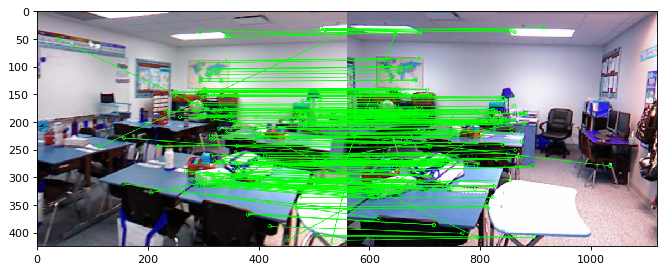

After RANSAC:


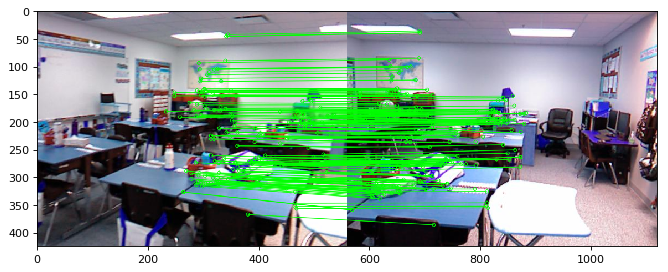

Essential matrix:
[[ 0.03528635 -0.64288702  0.00591349]
 [ 0.49341659  0.02860999 -0.50550657]
 [-0.0264357   0.29126999  0.00798598]]
Rotation:
[[ 0.93091564  0.04776478 -0.3620975 ]
 [-0.04716958  0.99883182  0.01048912]
 [ 0.36217552  0.0073155   0.93208121]]
Translation:
[[-0.41331871]
 [-0.01921728]
 [-0.91038362]]
[[ 2.01093932e+02 -1.00079762e+02 -8.64155536e+01  7.58626155e+01
   1.02391160e+02  8.60376854e+01 -2.17275593e+02 -2.19148232e+02
  -2.19497506e+02 -2.20954578e+02 -2.16717648e+02 -2.19676020e+02
  -2.39285400e+02 -2.39285400e+02 -2.31986772e+02 -2.14733153e+02
  -2.31372076e+02 -2.30190552e+02 -2.12960135e+02 -2.29142655e+02
  -2.30760233e+02 -2.10340313e+02 -2.28887388e+02 -2.14436623e+02
  -2.14191896e+02 -2.28607618e+02 -2.29520346e+02 -2.18574369e+02
  -2.30209497e+02 -2.12923531e+02 -2.16655371e+02  3.70077667e+01
  -2.15273890e+02 -2.28015057e+02 -2.08082235e+02 -2.15096528e+02
  -2.12147634e+02 -2.27875776e+02 -2.13017857e+02 -2.11478218e+02
  -2.12049743e+02

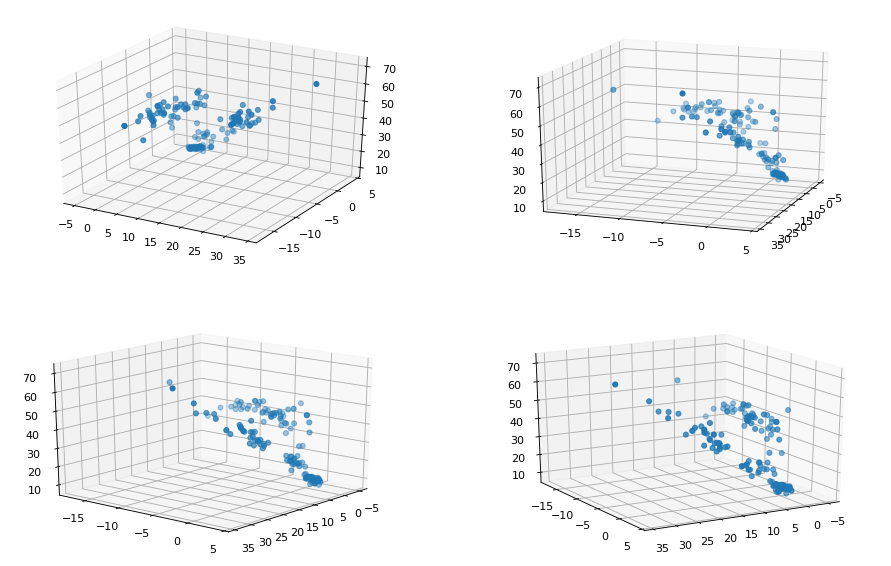

In [59]:
SFM('HW4_data/a1.png','HW4_data/a2.png')

Before RANSAC:


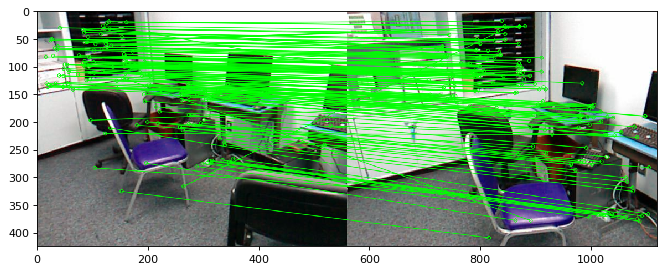

After RANSAC:


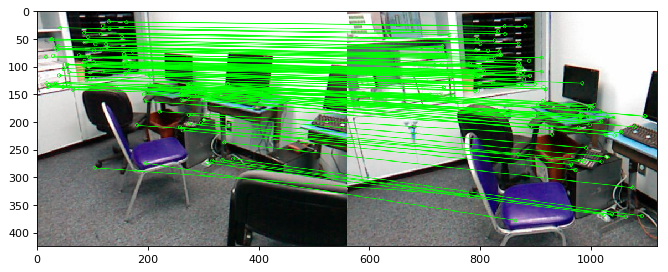

Essential matrix:
[[ 0.02594348 -0.59135081 -0.27692398]
 [ 0.64062882 -0.06831098 -0.07001068]
 [ 0.2957447   0.23831386  0.09334175]]
Rotation:
[[ 0.94272111 -0.10665497  0.31607219]
 [ 0.10759025  0.99408894  0.0145439 ]
 [-0.31575505  0.02029545  0.94862366]]
Translation:
[[ 0.38195359]
 [-0.40006709]
 [ 0.83310131]]
[[ 123.34609333  108.93571589  107.47021546  107.79233068  128.90350374
   106.87405328  129.76228186  129.76228186  122.74973904  125.98714594
   108.24373106  125.19498899  124.74137917  110.6782712   110.6782712
   128.0789267   107.12209375  107.12209375  113.92997837   77.971339
   115.03098914  108.09969341  114.58411408  112.10188019  107.93308882
   111.83057385  106.85122064  105.76806603  110.77253225  123.55071711
   129.40675038  129.40675038  119.83676156  119.83676156  118.78867967
   130.41762124  130.41762124  120.49587762  126.7643935   118.25289251
   113.5985867   118.75947897  200.62548344  200.62548344  128.80302481
   118.86526876  118.86526876  1

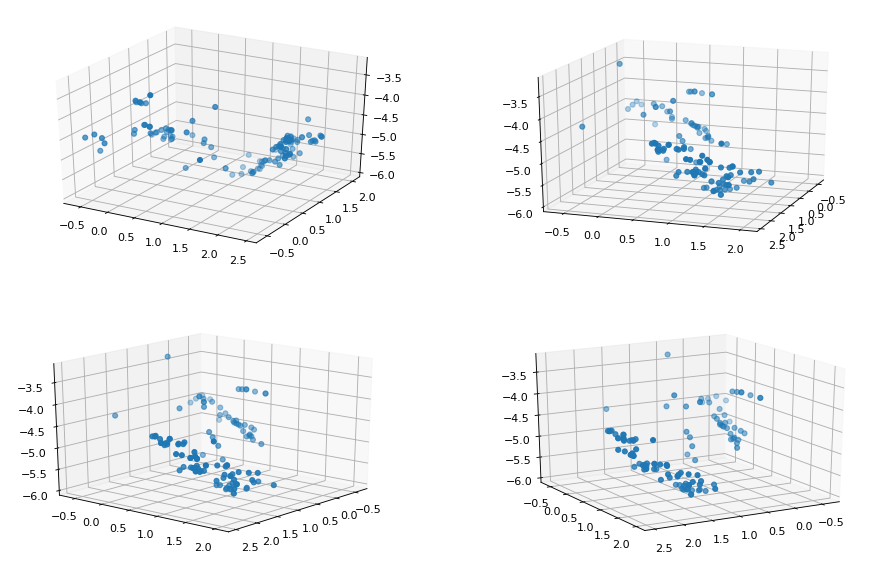

In [60]:
SFM('HW4_data/b1.png','HW4_data/b2.png')

Before RANSAC:


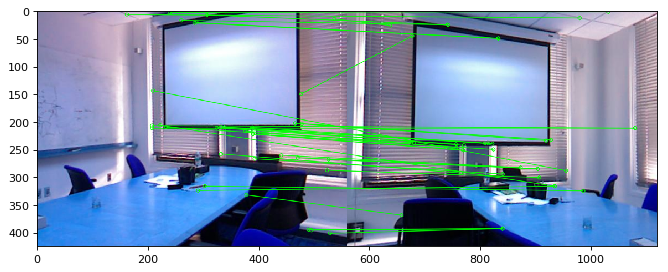

After RANSAC:


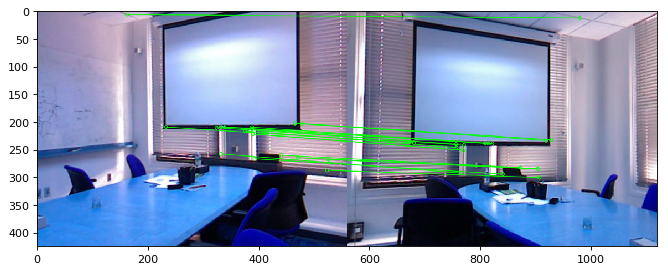

Essential matrix:
[[ 0.00473978  0.31054486  0.00603249]
 [ 0.39721785 -0.03937412  0.58356854]
 [-0.02344382 -0.6340427  -0.03253751]]
Rotation:
[[ 0.98971631 -0.01233748 -0.14251108]
 [-0.02016788 -0.99835704 -0.05363276]
 [-0.14161524  0.05595537 -0.98833907]]
Translation:
[[0.89833516]
 [0.01519329]
 [0.43904795]]
[[ 254.16463803  305.27205932  305.09656799  179.27481552  145.6831153
  -115.59387625  227.74827855  -80.2156471   -13.95595786  -17.65960166
    77.50463325  116.14446292 -126.27579725 -131.61464713 -131.67502499
   -88.23975696  -88.10324334 -183.15595437 -284.55666144 -181.84326039
  -130.9417333  -130.46835824 -184.43690297 -184.43690297 -117.57086148
  -133.65320043 -112.47464312 -132.63487612 -360.33746922 -115.69036789
  -216.808904   -221.82889301 -183.02221441 -188.42973696 -255.33307392
  -459.68615832]
 [ -30.02040456 -429.95548317 -434.9502494  -441.16830446 -530.86961285
  -451.17702105  -16.06799168  -47.77756839  -78.6934831   -78.04416059
  -648.60761944 

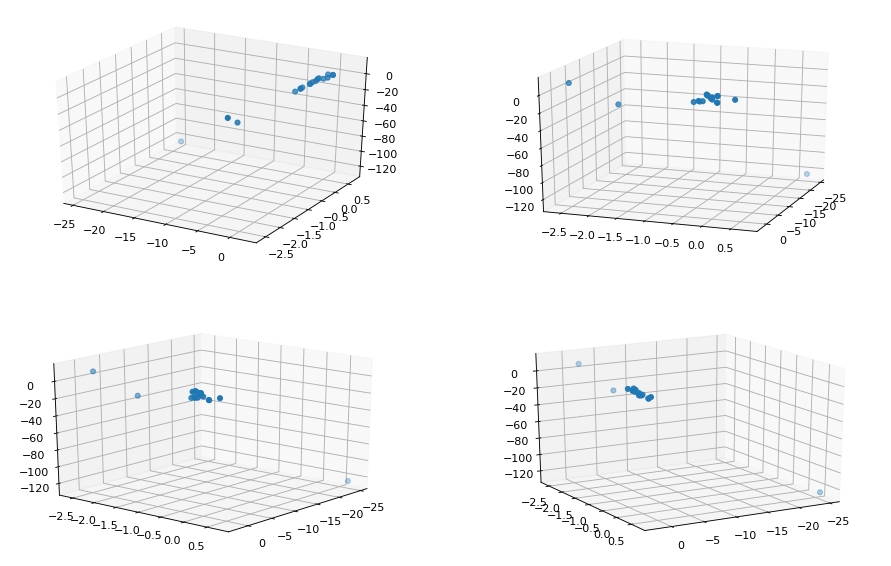

In [61]:
SFM('HW4_data/c1.png','HW4_data/c2.png')

### SFM:

Structure from motion pipeline consists of finding 3D matching points. Initially find the matching points and then filter the weak matches using RANSAC. Compute the Essential matrix and decompose it to Rotation and Translation matrices. Calculate the 3D points from triangulation and matching. Add subsequent views and perform above steps repeatedly and do bundle adjustments to get the dense points reconstruction of the 3D scene. 



### Matchings: 

Matchings are relatively better after performing RANSAC and filtering the weak matches.




### Translation Matrix:
  
Translation vector is recovered along with the rotation matrix from the essential matrix. Translation matrix in this context refers to the position of the camera of one image with respect to another image. from the translation vector, we can estimate the positions of cameras with respect to each other. we can observe that the first value represents the lateral movement of the camera, second value represents the relative change in height and third value represents the relative change in depth stating whether the camera is moved closer or farther away from the scene.


### Result:

If we observe the 3D plots we can observe that the matched points were plotted very well. Even the depth of the images were also relatively accurate in the 3d-plots from images. If we observe, in first two cases the matchings in the images are of varied depth and in the 3D plot we can observe that the points were distanct along Z-axis accounting the depth. In the last image pair, the matching was present relatively at the same depth around the projector screen, we can see a cluster of points in the last graph without much variation along the z-axis.


Finally, we can need more feature matches to construct the above images completely using 3D, as a result, more camera angles.